# 1. Overview of the project

In this project we will analyse energy consumption data coming from smart meters installed in different houses of London and try to make some predictions on the energy consumption.

The data are available in this link:
https://www.kaggle.com/jeanmidev/smart-meters-in-london

In this dataset, you will find a refactorised version of the data from the London data store, that contains the energy consumption readings for a sample of 5,567 London Households that took part in the UK Power Networks led Low Carbon London project between November 2011 and February 2014. The data from the smart meters seems associated only to the electrical consumption

Not all datasets shared in the link above will be used. We will concentrate in the following ones:
 - informations_households.csv : contains all the information on the households in the panel (their acorn group, their tariff) and in which block.csv.gz file their data are stored.
 - daily_dataset.zip: contains the block files with the daily information like the number of measures, minimum, maximum, mean, median, sum and std.
 - acorn_details.csv : Details on the acorn groups and their profile of the people in the group. The first three columns are the attributes studied, the ACORN-X is the index of the attribute. At a national scale, the index is 100 if for one column the value is 150 it means that there are 1.5 times more people with this attribute in the ACORN group than at the national scale. You can find an explanation on the CACI website.
 - weather_daily_darksky.csv : that contains the daily data from darksky api.
 
By using these dataset we are going to perform analysis through the correlation between different variables:

 - Weather conditions and energy consumptions,
 - Energy consumptions and demographic status (such as acorn group),
 - Energy consumptions based on weekdays and holiday correlation.

This part of analysis is largely inspired by the work done by Kaan Karambal in R, which is available here:
https://kaggle2.blob.core.windows.net/forum-message-attachments/266676/8231/BDA503_Project_SPACE.html
 
To finish, we will build some machine-learning models to predict the energy consumption.

# 2. Data preparation

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dates
% matplotlib inline

In [2]:
acorn_details = pd.read_csv('acorn_details.csv',encoding = 'ISO-8859-1')
acorn_details.info()
acorn_details.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826 entries, 0 to 825
Data columns (total 20 columns):
MAIN CATEGORIES    826 non-null object
CATEGORIES         826 non-null object
REFERENCE          826 non-null object
ACORN-A            826 non-null float64
ACORN-B            826 non-null float64
ACORN-C            826 non-null float64
ACORN-D            826 non-null float64
ACORN-E            826 non-null float64
ACORN-F            826 non-null float64
ACORN-G            826 non-null float64
ACORN-H            826 non-null float64
ACORN-I            826 non-null float64
ACORN-J            826 non-null float64
ACORN-K            826 non-null float64
ACORN-L            826 non-null float64
ACORN-M            826 non-null float64
ACORN-N            826 non-null float64
ACORN-O            826 non-null float64
ACORN-P            826 non-null float64
ACORN-Q            826 non-null float64
dtypes: float64(17), object(3)
memory usage: 129.1+ KB


,MAIN CATEGORIES,CATEGORIES,REFERENCE,ACORN-A,ACORN-B,ACORN-C,ACORN-D,ACORN-E,ACORN-F,ACORN-G,ACORN-H,ACORN-I,ACORN-J,ACORN-K,ACORN-L,ACORN-M,ACORN-N,ACORN-O,ACORN-P,ACORN-Q
0,POPULATION,Age,Age 0-4,77.0,83.0,72.0,100.0,120.0,77.0,97.0,97.0,63.0,119.0,67.0,114.0,113.0,89.0,123.0,138.0,133.0
1,POPULATION,Age,Age 5-17,117.0,109.0,87.0,69.0,94.0,95.0,102.0,106.0,67.0,95.0,64.0,108.0,116.0,86.0,89.0,136.0,106.0
2,POPULATION,Age,Age 18-24,64.0,73.0,67.0,107.0,100.0,71.0,83.0,89.0,62.0,104.0,459.0,97.0,96.0,86.0,117.0,109.0,110.0
3,POPULATION,Age,Age 25-34,52.0,63.0,62.0,197.0,151.0,66.0,90.0,88.0,63.0,132.0,145.0,109.0,96.0,90.0,140.0,120.0,120.0
4,POPULATION,Age,Age 35-49,102.0,105.0,91.0,124.0,118.0,93.0,102.0,103.0,76.0,111.0,67.0,99.0,98.0,90.0,102.0,103.0,100.0


In [3]:
info_households = pd.read_csv('informations_households.csv')
info_households.info()
info_households.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5566 entries, 0 to 5565
Data columns (total 5 columns):
LCLid            5566 non-null object
stdorToU         5566 non-null object
Acorn            5566 non-null object
Acorn_grouped    5566 non-null object
file             5566 non-null object
dtypes: object(5)
memory usage: 217.5+ KB


,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


In [4]:
info_households.tail()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
5561,MAC002056,Std,ACORN-U,ACORN-U,block_111
5562,MAC004587,Std,ACORN-U,ACORN-U,block_111
5563,MAC004828,Std,ACORN-U,ACORN-U,block_111
5564,MAC001704,ToU,ACORN-U,ACORN-U,block_111
5565,MAC002774,ToU,ACORN-U,ACORN-U,block_111


In [5]:
info_households[info_households['Acorn']=='ACORN-F']

,LCLid,stdorToU,Acorn,Acorn_grouped,file
2194,MAC003957,Std,ACORN-F,Comfortable,block_43
2195,MAC004059,Std,ACORN-F,Comfortable,block_43
2196,MAC001028,Std,ACORN-F,Comfortable,block_43
2197,MAC004777,Std,ACORN-F,Comfortable,block_43
2198,MAC004812,Std,ACORN-F,Comfortable,block_43
2199,MAC005002,Std,ACORN-F,Comfortable,block_43
2200,MAC000279,Std,ACORN-F,Comfortable,block_44
2201,MAC000856,Std,ACORN-F,Comfortable,block_44
2202,MAC005538,ToU,ACORN-F,Comfortable,block_44
2203,MAC004133,Std,ACORN-F,Comfortable,block_44


In [6]:
weather_daily = pd.read_csv('weather_daily_darksky.csv')
weather_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 32 columns):
temperatureMax                 882 non-null float64
temperatureMaxTime             882 non-null object
windBearing                    882 non-null int64
icon                           882 non-null object
dewPoint                       882 non-null float64
temperatureMinTime             882 non-null object
cloudCover                     881 non-null float64
windSpeed                      882 non-null float64
pressure                       882 non-null float64
apparentTemperatureMinTime     882 non-null object
apparentTemperatureHigh        882 non-null float64
precipType                     882 non-null object
visibility                     882 non-null float64
humidity                       882 non-null float64
apparentTemperatureHighTime    882 non-null object
apparentTemperatureLow         882 non-null float64
apparentTemperatureMax         882 non-null float64
uvIndex            

In [7]:
weather_daily.head()

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,...,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,...,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,...,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,...,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,...,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25
4,8.22,2011-12-24 23:00:00,252,partly-cloudy-night,2.79,2011-12-24 07:00:00,0.37,4.46,1028.17,2011-12-24 07:00:00,...,7.93,2011-12-24 08:06:15,2011-12-24 15:00:00,2011-12-24 13:00:00,Mostly cloudy throughout the day.,2011-12-24 19:00:00,-0.51,2011-12-24 23:00:00,2011-12-24 20:00:00,0.99


For weather daily information we are going to use “temperatureMaxTime” (to extract the date), “temperatureMin” and “temperatureHigh” variables (to calculate the average temperature per day).
<br>
We also are going to add “Year”,“Year_month” and “weekend” variables to this data.

In [8]:
dates_data = pd.to_datetime(weather_daily['temperatureMaxTime'])
dates_data.dt.to_period('D')

0     2011-11-11
1     2011-12-11
2     2011-12-27
3     2011-12-02
4     2011-12-24
5     2011-12-15
6     2011-11-19
7     2011-11-16
8     2011-12-12
9     2011-11-20
10    2011-11-08
11    2011-12-04
12    2011-12-16
13    2011-11-01
14    2011-12-26
15    2011-11-28
16    2011-12-09
17    2011-12-05
18    2011-11-24
19    2011-11-17
20    2011-12-13
21    2011-12-22
22    2011-12-06
23    2011-12-07
24    2011-11-21
25    2011-12-08
26    2011-11-06
27    2011-11-25
28    2011-12-01
29    2011-12-25
         ...    
852   2014-02-07
853   2014-03-13
854   2014-01-11
855   2014-01-21
856   2014-01-18
857   2014-01-04
858   2014-03-23
859   2014-02-25
860   2014-02-03
861   2014-02-28
862   2014-02-21
863   2014-01-07
864   2014-03-15
865   2014-02-26
866   2014-01-20
867   2014-03-29
868   2014-03-11
869   2014-02-02
870   2014-01-10
871   2014-03-05
872   2014-02-17
873   2014-01-30
874   2014-03-27
875   2014-03-24
876   2014-03-28
877   2014-01-26
878   2014-02-27
879   2014-03-

In [9]:
weekday = np.where(dates_data.dt.dayofweek < 5, 'Workday', 'Weekend')
weekday = pd.Series(weekday)
weather_daily['workday-Weekend'] = weekday
weather_daily['avgTemperature'] = ( weather_daily['temperatureHigh'] + weather_daily['temperatureMin'] ) / 2
weather_daily['year'] = dates_data.map(lambda x: x.strftime('%Y'))
weather_daily['year-month'] = dates_data.map(lambda x: x.strftime('%Y-%m'))
weather_daily[['workday-Weekend','avgTemperature','year','year-month']].head()

,workday-Weekend,avgTemperature,year,year-month
0,Workday,9.860,2011,2011-11
1,Weekend,5.535,2011,2011-12
2,Workday,9.180,2011,2011-12
3,Workday,4.960,2011,2011-12
4,Weekend,5.550,2011,2011-12


For inf_hh table:

 - Acorn_grouped variable doesn’t correctly match with acorn information that’s why we need to map acorn information with correct acorn groups.
 - Decided to select 4 blocks (Block_1, Block_10, Block_70, Block_75, Block_105) covering 5 main Acorn Group information (Affluent, Rising, Comfortable, Stretched, Adversity)
 - These 5 datasets will be combined under one big table called “all_blocks”
 - User informations in “inf_hh” table will be combined with “all_blocks” table

In [10]:
acorn_letter = info_households['Acorn'].unique()
acorn_group = info_households['Acorn_grouped'].unique()
acorn_class = dict()
acorn = info_households['Acorn']
for al in acorn_letter:
    acorn_class[al] = info_households['Acorn_grouped'].iloc[ acorn[acorn==al].index[0] ]
acorn_class

{'ACORN-': 'ACORN-',
 'ACORN-A': 'Affluent',
 'ACORN-B': 'Affluent',
 'ACORN-C': 'Affluent',
 'ACORN-D': 'Affluent',
 'ACORN-E': 'Affluent',
 'ACORN-F': 'Comfortable',
 'ACORN-G': 'Comfortable',
 'ACORN-H': 'Comfortable',
 'ACORN-I': 'Comfortable',
 'ACORN-J': 'Comfortable',
 'ACORN-K': 'Adversity',
 'ACORN-L': 'Adversity',
 'ACORN-M': 'Adversity',
 'ACORN-N': 'Adversity',
 'ACORN-O': 'Adversity',
 'ACORN-P': 'Adversity',
 'ACORN-Q': 'Adversity',
 'ACORN-U': 'ACORN-U'}

In [11]:
# mapping acorn information with correct acorn groups
acorn_class['ACORN-D'] = 'Rising'
acorn_class['ACORN-E'] = 'Rising'
acorn_class['ACORN-K'] = 'Stretched'
acorn_class['ACORN-L'] = 'Stretched'
acorn_class['ACORN-M'] = 'Stretched'
acorn_class['ACORN-N'] = 'Stretched'
acorn_class['ACORN-']  = 'NotPrivate_Household'
acorn_class['ACORN-U'] = 'NotPrivate_Household'
for al, ac in acorn_class.items():
    info_households['Acorn_grouped'][info_households['Acorn']== al] = ac

In [12]:
info_households[info_households['Acorn']=='ACORN-M']

,LCLid,stdorToU,Acorn,Acorn_grouped,file
4208,MAC000493,Std,ACORN-M,Stretched,block_84
4209,MAC002385,Std,ACORN-M,Stretched,block_84
4210,MAC003185,ToU,ACORN-M,Stretched,block_84
4211,MAC001955,Std,ACORN-M,Stretched,block_84
4212,MAC001783,Std,ACORN-M,Stretched,block_84
4213,MAC003786,Std,ACORN-M,Stretched,block_84
4214,MAC003563,Std,ACORN-M,Stretched,block_84
4215,MAC003590,Std,ACORN-M,Stretched,block_84
4216,MAC001046,Std,ACORN-M,Stretched,block_84
4217,MAC003605,ToU,ACORN-M,Stretched,block_84


In [13]:
blocks = ["block_1","block_10","block_70","block_75","block_105"]
info_blocks = info_households[info_households['file'].isin(blocks)]

In [14]:
info_blocks['Acorn_grouped'].value_counts()

Stretched      50
Affluent       50
Rising         50
Comfortable    50
Adversity      50
Name: Acorn_grouped, dtype: int64

In [15]:
block_1 = pd.read_csv('daily_dataset/block_1.csv')
block_10 = pd.read_csv('daily_dataset/block_10.csv')
block_70 = pd.read_csv('daily_dataset/block_70.csv')
block_75 = pd.read_csv('daily_dataset/block_75.csv')
block_105 = pd.read_csv('daily_dataset/block_105.csv')
block_1.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000323,2012-03-06,0.5460,0.567700,0.908,20,0.235788,11.354,0.138
1,MAC000323,2012-03-07,0.2195,0.386062,1.475,48,0.348265,18.531,0.054
2,MAC000323,2012-03-08,0.1695,0.290937,1.086,48,0.262756,13.965,0.056
3,MAC000323,2012-03-09,0.2605,0.423812,1.587,48,0.402155,20.343,0.068
4,MAC000323,2012-03-10,0.2680,0.373813,1.222,48,0.308453,17.943,0.061


In [16]:
blocks = [block_1, block_10, block_70, block_75, block_105]
all_blocks = pd.concat(blocks)

In [17]:
all_blocks = pd.merge(all_blocks,info_households, on = 'LCLid')

In [18]:
all_blocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157584 entries, 0 to 157583
Data columns (total 13 columns):
LCLid            157584 non-null object
day              157584 non-null object
energy_median    157580 non-null float64
energy_mean      157580 non-null float64
energy_max       157580 non-null float64
energy_count     157584 non-null int64
energy_std       157064 non-null float64
energy_sum       157580 non-null float64
energy_min       157580 non-null float64
stdorToU         157584 non-null object
Acorn            157584 non-null object
Acorn_grouped    157584 non-null object
file             157584 non-null object
dtypes: float64(6), int64(1), object(6)
memory usage: 16.8+ MB


In [19]:
all_blocks['day'] = pd.to_datetime(all_blocks['day'])
all_blocks['year'] = all_blocks['day'].dt.year
all_blocks['year-month'] = all_blocks['day'].map(lambda x: x.strftime('%Y-%m'))
all_blocks.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,stdorToU,Acorn,Acorn_grouped,file,year,year-month
0,MAC000323,2012-03-06,0.5460,0.567700,0.908,20,0.235788,11.354,0.138,Std,ACORN-A,Affluent,block_1,2012,2012-03
1,MAC000323,2012-03-07,0.2195,0.386062,1.475,48,0.348265,18.531,0.054,Std,ACORN-A,Affluent,block_1,2012,2012-03
2,MAC000323,2012-03-08,0.1695,0.290937,1.086,48,0.262756,13.965,0.056,Std,ACORN-A,Affluent,block_1,2012,2012-03
3,MAC000323,2012-03-09,0.2605,0.423812,1.587,48,0.402155,20.343,0.068,Std,ACORN-A,Affluent,block_1,2012,2012-03
4,MAC000323,2012-03-10,0.2680,0.373813,1.222,48,0.308453,17.943,0.061,Std,ACORN-A,Affluent,block_1,2012,2012-03


In [20]:
all_blocks.dropna(inplace=True)

In [21]:
all_blocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157064 entries, 0 to 157582
Data columns (total 15 columns):
LCLid            157064 non-null object
day              157064 non-null datetime64[ns]
energy_median    157064 non-null float64
energy_mean      157064 non-null float64
energy_max       157064 non-null float64
energy_count     157064 non-null int64
energy_std       157064 non-null float64
energy_sum       157064 non-null float64
energy_min       157064 non-null float64
stdorToU         157064 non-null object
Acorn            157064 non-null object
Acorn_grouped    157064 non-null object
file             157064 non-null object
year             157064 non-null int64
year-month       157064 non-null object
dtypes: datetime64[ns](1), float64(6), int64(2), object(6)
memory usage: 19.2+ MB


In [22]:
all_blocks['Acorn_grouped'].value_counts()

Stretched      32770
Adversity      31951
Rising         31703
Affluent       31609
Comfortable    29031
Name: Acorn_grouped, dtype: int64

# 3. Energy Consumption Analysis

## 3.1 Analysis of the monthly energy consumption throughout the years

In [23]:
# calculating the average temperature per month
weather_monthly = weather_daily.groupby('year-month')['avgTemperature'].mean().reset_index()

In [24]:
# calculatig the average and total energy consummption per month
energy_sum_mean = all_blocks.groupby('year-month')['energy_sum'].mean().reset_index()
energy_sum_total = all_blocks.groupby('year-month')['energy_sum'].sum().reset_index()
energy_sum_mean.rename(columns={'energy_sum': 'energy_sum_mean'}, inplace=True)
energy_sum_total.rename(columns={'energy_sum': 'energy_sum_total'}, inplace=True)

In [25]:
year_month_grp_eng = pd.concat([energy_sum_mean, energy_sum_total['energy_sum_total']], axis=1)

In [26]:
weather_monthly.drop(28,inplace=True)

In [27]:
all_year_month_eng_wth = pd.concat([weather_monthly,year_month_grp_eng['energy_sum_mean'] ,\
                                    year_month_grp_eng['energy_sum_total']],axis=1)

In [28]:
all_year_month_eng_wth['year'] = pd.to_datetime(all_year_month_eng_wth['year-month']).dt.year

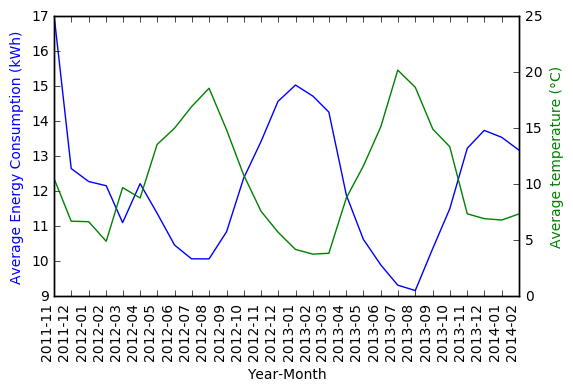

In [29]:
datelist = all_year_month_eng_wth['year-month'].values
converted_dates = map(datetime.datetime.strptime, datelist, len(datelist)*['%Y-%m'])
x_axis = list(converted_dates)
formatter = dates.DateFormatter('%Y-%m')
y_axis = all_year_month_eng_wth['energy_sum_mean'].values
y_axis2 = all_year_month_eng_wth['avgTemperature'].values
plt.plot( x_axis, y_axis,'b')
ax1 = plt.gcf().axes[0] 
ax1.xaxis.set_major_formatter(formatter)
ax2 = ax1.twinx()
ax2.plot(x_axis,y_axis2,'g')
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Average Energy Consumption (kWh)', color='b')
ax2.set_ylabel('Average temperature (°C)', color='g')
plt.xticks(x_axis)
plt.gcf().autofmt_xdate(rotation=90)
plt.show()

As expected the energy consumption decreases as the temperature increases and it increases as the temperatures decreases.
<br>
However the data on 2011-11 seems odd and shows a singular situation, as the energy consumption for this first month is the highest amount in our sample data.

## 3.2 Energy Consumption Differences Between Different Acorn Groups

In [30]:
all_bl = all_blocks[all_blocks.year != 2011]
ag_comp = all_bl.groupby(['year','Acorn_grouped'])['energy_sum'].sum()

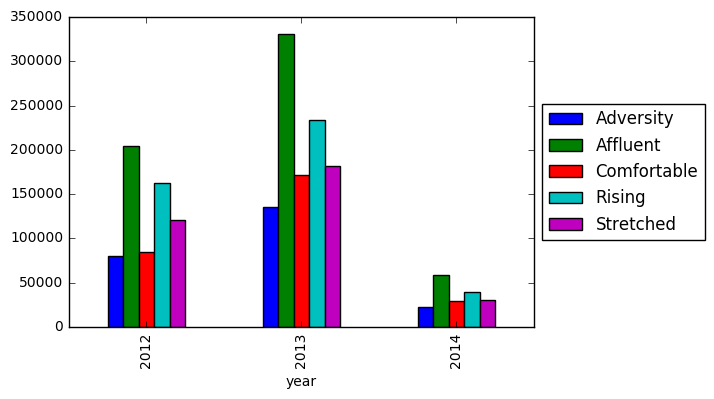

In [31]:
ag_comp.unstack().plot(kind='bar')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

As expected the wealthiest groups consume much more electricity than the underpriviledged groups.

## 3.3 Weekend & Workday Energy Consumption Comparison

In [32]:
weekday2 = np.where(all_blocks['day'].dt.dayofweek < 5, 'Workday', 'Weekend')
all_blocks['workday-Weekend'] = weekday2

In [33]:
all_bl2 = all_blocks[all_blocks.year.isin([2012,2013])]
ag_comp2 = all_bl2.groupby(['year','workday-Weekend'])['energy_sum'].sum()

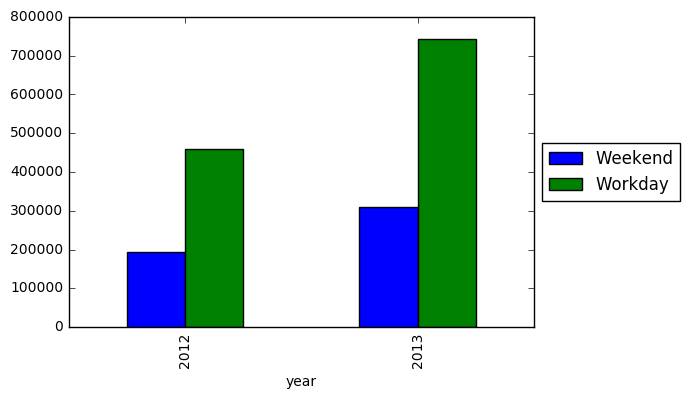

In [34]:
ag_comp2.unstack().plot(kind='bar')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [35]:
len(weather_daily['avgTemperature'])
#plt.scatter(weather_daily['avgTemperature'].values,all_blocks['energy_mean'].values)

882

In [36]:
#block_1_hh = pd.read_csv('halfhourly_dataset/block_1.csv')
#block_10_hh = pd.read_csv('halfhourly_dataset/block_10.csv')
#block_70_hh = pd.read_csv('halfhourly_dataset/block_70.csv')
#block_75_hh = pd.read_csv('halfhourly_dataset/block_75.csv')
#block_105_hh = pd.read_csv('halfhourly_dataset/block_105.csv')
#block_1_hh.head()

In [37]:
#blocks_hh = [block_1_hh, block_10_hh, block_70_hh, block_75_hh, block_105_hh]
#all_blocks_hh = pd.concat(blocks_hh)
#all_blocks_hh.info()

In [38]:
#dates_hh = pd.to_datetime(all_blocks_hh['tstp'])

In [39]:
#all_blocks_hh['year'] = dates_hh.map(lambda x: x.strftime('%Y'))
#all_blocks_hh['year-month'] = dates_hh.map(lambda x: x.strftime('%Y-%m'))
#all_blocks_hh['year-month'] = dates_hh.map(lambda x: x.strftime('%Y-%m'))
#all_blocks_hh.head()

In [40]:
#all_blocks_hh['y_day'] = dates_hh.map(lambda x: x.timetuple().tm_yday)
#all_blocks_hh_2013 = all_blocks_hh[all_blocks_hh['year']=='2013']
#all_blocks_hh_2013.head()

In [41]:
#hh = dates_hh.map(lambda x: x.strftime('%H:%M:%S'))
#hh_2013 = hh[hh=='2013']

# 4. Predictions on the energy consumption

As a first step let's try to predict the energy consumption per month using a single dependent variable: the average temperature.
<br>
Let's plot the set of points to see if they follow a common shape.

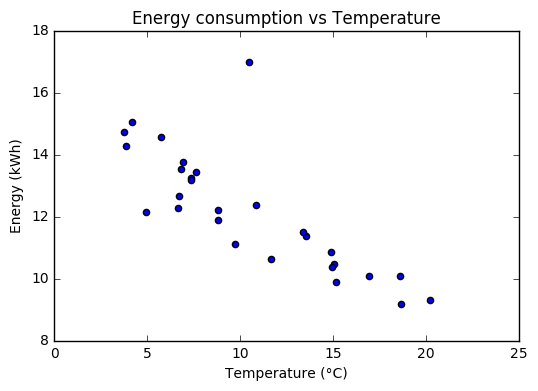

In [42]:
plt.scatter(all_year_month_eng_wth['avgTemperature'].values,all_year_month_eng_wth['energy_sum_mean'].values)
plt.title('Energy consumption vs Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Energy (kWh)')
plt.show()

It seems that the energy varies linearly (negatively) with the temperature.
<br>
A linear regression model would be a great starting point for our machine learning models.

In [43]:
# Splitting the dataset into training set and test set
from sklearn.cross_validation import train_test_split
X = all_year_month_eng_wth['avgTemperature'].values
y = all_year_month_eng_wth['energy_sum_mean'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

In [44]:
# Linear regression model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [45]:
y_pred = regressor.predict(X_test)

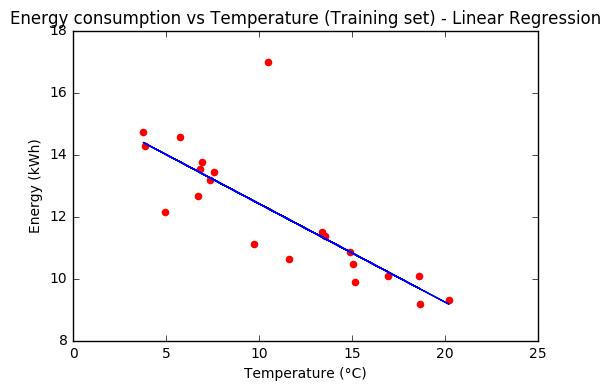

In [46]:
# plotting the dataset and the predicted values by the linear regression model
plt.scatter(X_train, y_train, color = 'red')
plt.plot(X_train, regressor.predict(X_train), color = 'blue')
plt.title('Energy consumption vs Temperature (Training set) - Linear Regression')
plt.xlabel('Temperature (°C)')
plt.ylabel('Energy (kWh)')
plt.show()

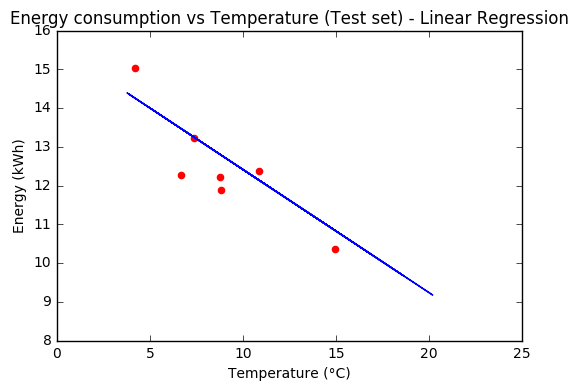

In [47]:
plt.scatter(X_test, y_test, color = 'red')
plt.plot(X_train, regressor.predict(X_train), color = 'blue')
plt.title('Energy consumption vs Temperature (Test set) - Linear Regression')
plt.xlabel('Temperature (°C)')
plt.ylabel('Energy (kWh)')
plt.show()

Now, let's compare this linear regression model with other ML models: SVR, K-NN, and Random Forest regressions.
<br>
We will first perform k-fold cross validation for each of these models and apply the mean squared error as a metrics.

In [56]:
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import ShuffleSplit
#kf = KFold(n_splits=10, shuffle=True)
X = all_year_month_eng_wth['avgTemperature']
X = X.reshape(-1, 1)
y = all_year_month_eng_wth['energy_sum_mean']
lm = LinearRegression()
cv = ShuffleSplit(len(y), n_iter=5, test_size =0.25, random_state=0)
sc = 'mean_squared_error'
scs = cross_val_score(lm, X, y, scoring = sc,cv=cv)
lm_sc = np.mean(scs)
print(scs)
print('Average of the mean squared errors with linear regression : {0:.2f}'.format(lm_sc) )
#for train_index, test_index, in kf.split(X):
#    X_train = X.iloc[train_index]
#    X_test = X.iloc[test_index]
#    y_train = y.iloc[train_index]
#    y_test = y.iloc[test_index]
#    regressor.fit(X_train, y_train)
#    predictions = regressor.predict(X_test)
#    mse = mean_squared_error(y_test, predictions)
#    rmse = np.sqrt(mse)
#    rmse_values.append(rmse)

[-0.49235977 -0.3194664  -0.57453781 -3.84713631 -0.25365841]
Average of the mean squared errors with linear regression : -1.10


In [58]:
from sklearn.svm import SVR
svr_reg = SVR(kernel = 'rbf')
scs = cross_val_score(svr_reg, X, y, scoring = sc,cv=cv)
svr_sc = np.mean(scs)
print(scs)
print('Average of the mean squared errors with SVR : {0:.2f}'.format(svr_sc) )

[-0.86447735 -1.60919009 -1.93432232 -4.42310347 -1.79190361]
Average of the mean squared errors with SVR : -2.12


In [59]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators = 10, random_state = 0)
scs = cross_val_score(rf_reg, X, y, scoring = sc,cv=cv)
rf_sc = np.mean(scs)
print(scs)
print('Average of the mean squared errors with random forest regression : {0:.2f}'.format(rf_sc) )

[-1.26966768 -2.63108442 -1.31534074 -4.08207734 -0.30623883]
Average of the mean squared errors with random forest regression : -1.92


In [60]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
scs = cross_val_score(knn, X, y, scoring = sc,cv=cv)
knn_sc = np.mean(scs)
print(scs)
print('Average of the mean squared errors with the knn regression : {0:.2f}'.format(knn_sc) )

[-1.21295955 -0.3941587  -1.00155721 -4.48038413 -0.7588855 ]
Average of the mean squared errors with the knn regression : -1.57


Finally the most accurate model seems to be the simplest one: linear regression !
<br>
Now let's plot the predicted energy consumption based on the linear regression model throughout the years.

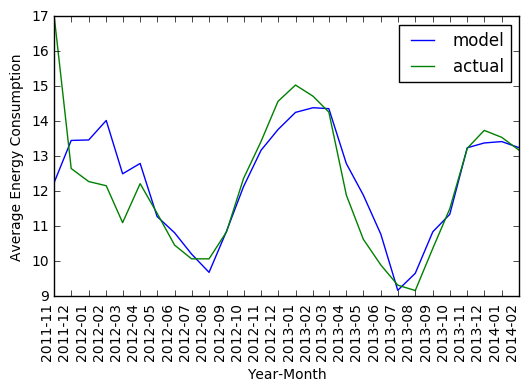

In [52]:
datelist = all_year_month_eng_wth['year-month'].values
converted_dates = map(datetime.datetime.strptime, datelist, len(datelist)*['%Y-%m'])
x_axis = list(converted_dates)
formatter = dates.DateFormatter('%Y-%m')
plt.plot(x_axis, regressor.predict(X), color = 'blue')
ax1 = plt.gcf().axes[0] 
ax1.xaxis.set_major_formatter(formatter)
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Average Energy Consumption')
plt.plot(x_axis, y, color = 'green')
#plt.title('Salary vs Experience (Training set)')
#plt.xlabel('Years of Experience')
#plt.ylabel('Salary')
plt.legend(['model','actual'])
plt.xticks(x_axis)
plt.gcf().autofmt_xdate(rotation=90)
plt.show()

Not so bad !
<br>
We notice a better aggrement between both curves from May 2012. That means from this period the energy consumption depends mostly on the temperature. Other factors have less influence.
<br>
To note that this date is the same when the total energy consumption reaches its peak and does not increase any more.